In [1]:
import os
import re
import json
import random
from pprint import pprint
from ast import literal_eval
from collections import Counter

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()

In [2]:
random.seed(2021)
np.random.seed(2021)

In [3]:
exportdata = pd.read_csv("exportdata.csv")
entries = pd.read_csv("entries_of_projects_chosen_by_patrice.csv")
af_widgets = pd.read_csv("af_widgets_of_interest.csv")
projects = pd.read_csv("projects_chosen_by_patrice.csv")
exportables = pd.read_csv("af_exportables.csv")
##
afs = pd.read_csv("analysis_frameworks.csv")
users = pd.read_csv("user_names.csv")


/home/selim/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
dirName = 'generated_entries'
if not os.path.exists(dirName):
    os.mkdir(dirName)

In [5]:
af_widgets.head()

,id,widget_id,title,properties,analysis_framework_id,key
0,483,multiselectWidget,SPECIFIC NEEDS GROUPS,"{""data"": {""options"": [{""key"": ""option-1"", ""lab...",137,element7
1,484,dateWidget,DATE OF INFORMATION,"{""added_from"": ""list"", ""list_grid_layout"": {""t...",137,element8
2,475,excerptWidget,EXCERPT,"{""added_from"": ""overview"", ""list_grid_layout"":...",137,page-two-excerpt
3,482,multiselectWidget,DEMOGRAPHIC GROUPS,"{""data"": {""options"": [{""key"": ""option-1"", ""lab...",137,element6
4,479,scaleWidget,RELIABILITY,"{""data"": {""scale_units"": [{""key"": ""scale-1"", ""...",137,element3


In [6]:
af_widgets["properties"] = af_widgets["properties"].apply(json.loads)

In [7]:
af_widgets["title"].str.upper().unique()

array(['SPECIFIC NEEDS GROUPS', 'DATE OF INFORMATION', 'EXCERPT',
       'DEMOGRAPHIC GROUPS', 'RELIABILITY', 'SEVERITY', 'AFFECTED GROUPS',
       'MATRIX 1D', 'SECTORAL INFORMATION', 'LOCATION',
       'OPERATIONAL ENVIRONMENT', 'IN-CRISIS', 'INFORMATION DATE',
       'SECTORS', 'FLAG', 'PRE-CRISIS', 'CROSS SECTOR', 'GEO LOCATION',
       'CROSS SECTORS', 'MATRIX 2D', 'CRISIS TYPE', 'POPULATION GROUPS',
       'SHOCK/EVENT', 'DISPLACED POP TYPE', 'HIGH LEVEL TAGS',
       'ADDITIONAL CONTEXT', 'CLEANING TAGS', 'CLEANING COMMENTS',
       'COMMENT', 'RESPONSE TYPE', 'CONTEXT ADDITIONAL TAGS'],
      dtype=object)

In [8]:
mat2d_titles = [
    s.upper() for s in [
        "Pre-Crisis",
        "Shock/Event",
        "In-Crisis",
        "Sectors",
        "Sectoral Information",
        "Matrix 2D",
    ]
]
mat2d_properties_ids = af_widgets[(
    af_widgets["title"].str.upper()).isin(mat2d_titles)][[
        "properties", "analysis_framework_id"
    ]]
mat2d_properties = mat2d_properties_ids["properties"].tolist()
mat2d_ids = mat2d_properties_ids["analysis_framework_id"].tolist()

In [9]:
afids_pillars_subpillars = dict()
errors = []
for mat, af_id in zip(mat2d_properties, mat2d_ids):
    try:
        dims = mat["data"]['dimensions']
        afids_pillars_subpillars[af_id] = {}
        for dim in dims:
            pillar = dim["title"]
            sub_pillars = []
            for sub_pillar_dict in dim["subdimensions"]:
                sub_pillars.append(sub_pillar_dict["title"])
            afids_pillars_subpillars[af_id][pillar] = sub_pillars
    except KeyError:
        errors.append(mat)


In [10]:
exportables["data"] = exportables["data"].apply(json.loads)

In [11]:
exportables["data"][0]['excel']

{'title': 'SPECIFIC NEEDS GROUPS'}

In [12]:
def extract_title(x):
    if x["excel"].get("title"):
        return x["excel"]["title"]
    elif x["excel"].get("type") == "multiple":
        return x["excel"]["titles"]
    
def title_case(tag):
    if isinstance(tag, (list, tuple)):
        return tuple([x.title() for x in tag])
    return tag.title()

af_titles = exportables["data"].apply(extract_title)

In [13]:
entries.shape, exportdata.shape

((200243, 21), (1203311, 4))

In [14]:
entries[~entries["excerpt"].isna()]["excerpt"].unique().shape

(153382,)

In [15]:
exid_to_exdata = dict()
for ex_id, ex_data in zip(exportables["id"], exportables["data"]):
    exid_to_exdata[ex_id] = ex_data

In [16]:
# additional tags:
# Reliability, Severity, geo location, crisis type, affected groups, 

In [17]:
af_widgets["title"].unique()

array(['SPECIFIC NEEDS GROUPS', 'DATE OF INFORMATION', 'EXCERPT',
       'DEMOGRAPHIC GROUPS', 'RELIABILITY', 'SEVERITY', 'AFFECTED GROUPS',
       'Matrix 1D', 'Sectoral Information', 'LOCATION',
       'Operational Environment', 'IN-CRISIS', 'Information Date',
       'Sectors', 'Flag', 'Severity', 'PRE-CRISIS', 'Cross sector',
       'Affected groups', 'Specific Needs Groups', 'Demographic Groups',
       'Reliability', 'Geo Location', 'Excerpt', 'Information date',
       'Cross Sectors', 'Matrix 2D', 'Crisis type', 'POPULATION GROUPS',
       'SHOCK/EVENT', 'Crisis Type', 'DISPLACED POP TYPE',
       'HIGH LEVEL TAGS', 'Additional Context', 'CLEANING tags',
       'Cleaning comments', 'Comment', 'Response Type',
       'Context additional tags'], dtype=object)

In [18]:
widget_key_id_to_title = dict()
for w_key, w_id, title in zip(af_widgets["key"], af_widgets["widget_id"], af_widgets["title"]):
    widget_key_id_to_title[(w_key, w_id)] = title

In [19]:
def exportdata_to_tag_title(row):
    data = json.loads(row[1])
    wkey, wid = None, None
    if data.get("common"):
        wkey = data.get("common").get("widget_key")
        wid = data["common"].get("widget_id")
    if wkey and wid:
        if widget_key_id_to_title.get((wkey, wid)):
            return widget_key_id_to_title.get((wkey, wid))
    if data.get("report") and data["report"].get("other"):
            if len(data["report"]["other"]) == 1 and data["report"]["other"][0].get("title"):
                if data["report"]["other"][0]["title"]:
                    return data["report"]["other"][0]["title"]
    if isinstance(data.get("excel"), list) and len(data["excel"])==1 and \
     data["excel"][0].get("widget_key") and data["excel"][0].get("widget_id"):
        wkey = data["excel"][0]["widget_key"]
        wid = data["excel"][0]["widget_id"]
        if widget_key_id_to_title.get((wkey, wid)):
            return widget_key_id_to_title.get((wkey, wid))
    exportable_id = row[3]
    if exid_to_exdata[exportable_id]["excel"].get("title"):
        return exid_to_exdata[exportable_id]["excel"]["title"]
    elif exid_to_exdata[exportable_id]["excel"].get("type") == "multiple":
        return exid_to_exdata[exportable_id]["excel"]["titles"]
    raise

In [20]:
exportdata["tag_title"] = exportdata.apply(exportdata_to_tag_title, axis=1)

In [21]:
def exportdata_to_tag_value(row):
    data = json.loads(row[1])
    if isinstance(data["excel"], list) and len(data["excel"])==1:
        return data["excel"][0]["value"]
    if data["excel"].get("type") == "lists":
        return data["excel"]["values"]
    if isinstance(data["excel"], dict) and "value" in data["excel"]:
        return data["excel"].get("value")
    if isinstance(data["excel"], dict) and "values" in data["excel"]:
        return data["excel"].get("values")
    elif "values" in data["common"]:
        return data["common"]["values"]
    elif "value" in data["common"]:
        return data["common"]["value"]
    raise

In [22]:
exportdata["tag_value"] = exportdata.apply(exportdata_to_tag_value, axis=1)

In [23]:
def title_case(tag):
    if isinstance(tag, (list, tuple)):
        return tuple([x.title() for x in tag])
    return tag.title()

In [24]:
exportdata["tag_title"] = exportdata["tag_title"].apply(title_case)

In [25]:
#exportdata["tag_title"].unique()
# 1. GIMAC --> Pre-Crisis, Shock/Event, In-Crisis
# 2. 2020 Okular --> Sectoral Information
# 3. Okular Analytics Generic --> Sectoral Information
# 4. Rohingya Framework --> Sectors
# 5. IFRC 2018 --> Sectors
# 6. Colombia AF --> Sectoral Information
# 7. Nigeria Situation Analysis (OA) --> Sectoral Information
# 8. Situation Analysis Generic Yemen --> Matrix 2D
# 9. Situation Analysis Generic Libya --> Sectors

In [26]:
secondary_tags_titles = [
        "Severity",
        "Reliability",
        "Demographic Groups",
        "Specific Needs Groups",
        "Location",
        "Information Date",
#        "Affected Groups"
]

In [27]:
exportdata_secondary_tags = exportdata[exportdata["tag_title"].isin(secondary_tags_titles)]

In [28]:
exportdata_secondary_tags.shape, exportdata.shape, entries.shape

((779736, 6), (1203311, 6), (200243, 21))

In [29]:
entries_labeled_secondary_tags = pd.merge(entries,
                                 exportdata_secondary_tags,
                                 how="inner",
                                 left_on="id",
                                 right_on="entry_id",
                                 suffixes=('_entry', '_exportdata'))

In [30]:
entries.shape, entries[~entries["excerpt"].isna()]["excerpt"].unique().shape, exportdata_secondary_tags.shape

((200243, 21), (153382,), (779736, 6))

In [31]:
entries.head()

,id,created_at,modified_at,excerpt,image_raw,analysis_framework_id,created_by_id,lead_id,modified_by_id,entry_type,...,order,client_id,project_id,tabular_field_id,dropped_excerpt,highlight_hidden,verified,verification_last_changed_by_id,image_id,title
0,25639,2019-03-24 11:25:28.055219+00,2019-03-25 04:27:17.715687+00,"On March 19, search-andrescue personnel airlif...",NaN,273,26,10607,26,excerpt,...,13,odi4z54i,878,NaN,NaN,False,False,NaN,NaN,"IFRC - Cyclone Idai, March 2019"
1,54325,2019-08-13 08:51:01.120935+00,2021-05-06 07:14:14.773704+00,NaN,https://api.thedeep.io/file/19293/,829,1395,16973,1395,image,...,17,ptmusm3b,1186,NaN,NaN,False,False,NaN,19293.0,UNHCR Chile
2,102051,2020-05-28 10:15:38.075272+00,2020-06-17 10:23:13.365974+00,"Currently, there are 139,771 confirmed cases i...",NaN,699,26,28940,657,excerpt,...,2,c5jrys5cq7vvjxju,1142,NaN,NaN,False,False,NaN,NaN,IFRC Turkey
3,65692,2019-10-09 11:40:11.416419+00,2021-05-06 07:14:31.449556+00,NaN,https://api.thedeep.io/file/23416/,829,1396,18714,1396,image,...,21,a7dfeews,1183,NaN,NaN,False,False,NaN,23416.0,UNHCR Colombia
4,21660,2019-02-08 11:27:52.756824+00,2019-02-08 11:27:53.091176+00,"According to The Guardian, more than 9,000 ref...",NaN,552,657,8644,657,excerpt,...,2,x8t1upes,788,NaN,"According to The Guardian, more than 9,000 ref...",False,False,NaN,NaN,Nigeria Situation Analysis (OA)


In [32]:
exportdata_secondary_tags.head()

,id,data,entry_id,exportable_id,tag_title,tag_value
0,1633665,"{""excel"": [{""value"": null, ""version"": 1, ""widg...",338269,8625,Severity,None
1,1633664,"{""excel"": {""value"": ""Usually Reliable""}, ""comm...",338269,8623,Reliability,Usually Reliable
3,1633662,"{""excel"": {}, ""common"": {""values"": [""20-05-202...",338269,8621,Information Date,"[20-05-2021, None]"
4,1633661,"{""excel"": {""polygons"": []}, ""common"": {""values...",338269,8619,Location,[486383]
8,998798,"{""excel"": {""polygons"": []}, ""common"": {""values...",202094,9458,Location,[517928]


In [33]:
leads = entries_labeled_secondary_tags.lead_id.unique()

In [34]:
entries_labeled_secondary_tags_cleaned =\
                entries_labeled_secondary_tags[~entries_labeled_secondary_tags["excerpt"].isna()]\
                                    .drop(columns=['tabular_field_id',
                                                   'image_id',
                                                   'image_raw', 
                                                   'created_at', 
                                                   'modified_at', 
                                                   'created_by_id', 
                                                   'modified_by_id',
                                                   'entry_type', 
                                                   'dropped_excerpt', 
                                                   'highlight_hidden', 
                                                   'verified', 
                                                   'verification_last_changed_by_id', 
                                                   'client_id',
                                                   'id_exportdata',
                                                   'information_date',
                                                   'order',
                                                   'id_entry',
                                                   'data'])

In [35]:
entries_labeled_secondary_tags_cleaned.shape, entries_labeled_secondary_tags_cleaned.columns

((563003, 9),
 Index(['excerpt', 'analysis_framework_id', 'lead_id', 'project_id', 'title',
        'entry_id', 'exportable_id', 'tag_title', 'tag_value'],
       dtype='object'))

In [36]:
entries_labeled_secondary_tags_cleaned.tag_title.unique()

array(['Information Date', 'Reliability', 'Severity', 'Location',
       'Demographic Groups', 'Specific Needs Groups'], dtype=object)

In [37]:
entries_labeled_secondary_tags_cleaned.head(2)

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_title,tag_value
0,"On March 19, search-andrescue personnel airlif...",273,10607,878,"IFRC - Cyclone Idai, March 2019",25639,3148,Information Date,22-03-2019
1,"On March 19, search-andrescue personnel airlif...",273,10607,878,"IFRC - Cyclone Idai, March 2019",25639,3145,Reliability,Usually


In [38]:
reliability_raw_to_processed_dict = {
    'Completely':'Completely Reliable',
    'Completely Reliable':'Completely Reliable',
    'Usually Reliable':'Usually reliable',
    'Usually':'Usually reliable',
    'Fairly Reliable':'Fairly Reliable',
    'Fairly':'Fairly Reliable',
    'Not Usually':'Not Usually Reliable',
    'Not Usually Reliable':'Not Usually Reliable',
    'Unreliable':'Unreliable',
    'Cannot be Used':'Unreliable',
    'Unreliable ':'Unreliable'
}

In [39]:
reliabillity_tags_df = entries_labeled_secondary_tags_cleaned[entries_labeled_secondary_tags_cleaned.tag_title=='Reliability']\
                            .drop(columns=['tag_title'])
reliabillity_tags_df['tag_value'] =\
            reliabillity_tags_df['tag_value'].apply(lambda x: [reliability_raw_to_processed_dict[x]])

In [40]:
reliabillity_tags_df.head(2)

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_value
1,"On March 19, search-andrescue personnel airlif...",273,10607,878,"IFRC - Cyclone Idai, March 2019",25639,3145,[Usually reliable]
9,"Currently, there are 139,771 confirmed cases i...",699,28940,1142,IFRC Turkey,102051,5295,[Usually reliable]


In [41]:
#reliabillity_tags_df.to_csv('data_secondary_tags/reliabillity_tags.csv')

## Dates

In [42]:
date_tags_df =\
    entries_labeled_secondary_tags_cleaned[entries_labeled_secondary_tags_cleaned.tag_title=='Information Date']\
                            .drop(columns=['tag_title'])

date_tags_df = date_tags_df[date_tags_df.tag_value.apply(
                    lambda x: x!=None and x!=[None, None]
            )]

In [43]:
date_tags_df.head()

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_value
0,"On March 19, search-andrescue personnel airlif...",273,10607,878,"IFRC - Cyclone Idai, March 2019",25639,3148,22-03-2019
11,"Currently, there are 139,771 confirmed cases i...",699,28940,1142,IFRC Turkey,102051,5300,"[11-05-2020, None]"
84," Mt. Pinatubo eruption, June 1991, Atmosphere...",699,12919,1111,IFRC Philippines,33155,5300,"[01-06-1991, None]"
89,"In addition, there are 922,530* foreign nation...",699,26544,1142,IFRC Turkey,96087,5300,"[01-01-2019, 31-03-2020]"
98,"""He has the support, up until now, of the arme...",273,10740,786,Venezuela crisis 2019,26269,3148,23-03-2019


In [44]:
#date_tags_df.to_csv('data_secondary_tags/date_tags.csv')


## Locations:

In [45]:
geoarea_df = pd.read_csv('geo_geoarea.csv')

In [46]:
geo_location_data =\
    entries_labeled_secondary_tags_cleaned[
        entries_labeled_secondary_tags_cleaned.tag_title.apply(lambda x: "Location" in (x))
    ].drop(columns=['tag_title'])
geo_location_data.head()

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_value
8,"Currently, there are 139,771 confirmed cases i...",699,28940,1142,IFRC Turkey,102051,5304,[215265]
17,"According to The Guardian, more than 9,000 ref...",552,8644,788,Nigeria Situation Analysis (OA),21660,4691,[29687]
36,SANCAKTEPE SUB-PROVINCE: According to Baseline...,699,25511,1142,IFRC Turkey,96070,5304,[215807]
82," Mt. Pinatubo eruption, June 1991, Atmosphere...",699,12919,1111,IFRC Philippines,33155,5304,[221420]
87,"In addition, there are 922,530* foreign nation...",699,26544,1142,IFRC Turkey,96087,5304,[215265]


In [47]:
geoarea_cleaned = geoarea_df[['id', 'title']].dropna()
geoarea_cleaned['title'] = geoarea_cleaned['title'].apply(lambda x: x.replace('(the)','')\
                                                                        .replace('(la)','').lstrip().rstrip())

list_dicts = geoarea_cleaned.to_dict(orient='split')['data']
id_to_location = {}
for row in list_dicts:
    id_to_location[row[0]] = row[1]
list_keys = list(id_to_location.keys())

In [48]:
def perfectEval(anonstring):
    corrected = [int(nb) for nb in anonstring]
    return corrected

In [49]:
geo_location_data['tag_value'] = geo_location_data['tag_value'].apply(lambda x: perfectEval(x))

In [50]:
n = 1000
final_df = pd.DataFrame()
for i in tqdm(range(0,geo_location_data.shape[0],n)):
    tmp_df = geo_location_data[i:i+n].copy()
    tmp_df['tag_value'] = tmp_df.tag_value\
                            .apply(lambda x: [id_to_location[int(tag_)] for tag_ in x if int(tag_) in list_keys])
    final_df = final_df.append(tmp_df)

  0%|          | 0/139 [00:00<?, ?it/s]

In [51]:
geo_loc_df = final_df.copy()
geo_loc_df

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_value
8,"Currently, there are 139,771 confirmed cases i...",699,28940,1142,IFRC Turkey,102051,5304,[Turkey]
17,"According to The Guardian, more than 9,000 ref...",552,8644,788,Nigeria Situation Analysis (OA),21660,4691,[Nigeria]
36,SANCAKTEPE SUB-PROVINCE: According to Baseline...,699,25511,1142,IFRC Turkey,96070,5304,[Sancaktepe]
82," Mt. Pinatubo eruption, June 1991, Atmosphere...",699,12919,1111,IFRC Philippines,33155,5304,[Philippines]
87,"In addition, there are 922,530* foreign nation...",699,26544,1142,IFRC Turkey,96087,5304,[Turkey]
...,...,...,...,...,...,...,...,...
740032,Une structure sanitiare est fonctionnelle à Dj...,1306,63087,2225,IMMAP/DFS RDC,412992,8619,[Djugu]
740037,"Dans la localité de Djaiba, les enseignants on...",1306,63087,2225,IMMAP/DFS RDC,412991,8619,[Djugu]
740041,L'activité économique a fortement ralenti en 2...,1306,63089,2225,IMMAP/DFS RDC,413010,8619,[République démocratique du Congo]
740045,"L'inflation a grimpé en flèche, alimentée par ...",1306,63089,2225,IMMAP/DFS RDC,413011,8619,[République démocratique du Congo]


In [52]:
final_df = final_df[final_df.tag_value.apply(lambda x: bool(len(x)) and 'Unknown' not in x)]

In [53]:
#final_df.to_csv('data_secondary_tags/geo_location.csv')

In [54]:
#geo_location_df.to_csv('data_secondary_tags/geo_location.csv')

## Severity

In [55]:
Severity_raw_to_processed_dict = {
    'Critical':'Critical',
    'Severe':'Critical',
    'Critical Situation':'Critical',
    'Critical problem. Urgent intervention required':'Critical',
    'Severe Conditions':'Critical',
    'Major':'Major',
    'Severe Problem. Intervention required':'Major',
    'Important problem. Middle to short term intervention required':'Major',
    'Situation of Major Concern':'Major',
    'Of Concern. Monitoring required':'Of Concern',
    'Of Concern':'Of Concern',
    'Situation of Concern':'Of Concern',
    'No Problem':'No problem',
    'Minor Problem':'Minor Problem',
    None:None
    
}

In [56]:
severity_tags_df = entries_labeled_secondary_tags_cleaned[entries_labeled_secondary_tags_cleaned.tag_title=='Severity']\
                            .drop(columns=['tag_title'])

severity_tags_df = severity_tags_df[
    severity_tags_df.tag_value.apply(lambda x: (x!='No problem/minor problem. No intervention required') and\
                                    (x!='No problem/Minor Problem'))]

severity_tags_df['tag_value'] =\
            severity_tags_df['tag_value'].apply(lambda x: Severity_raw_to_processed_dict[x])

severity_tags_df = severity_tags_df.dropna()
severity_tags_df['tag_value'] = severity_tags_df['tag_value'].apply(lambda x: [x])

In [57]:
severity_tags_df.head()

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_value
2,"On March 19, search-andrescue personnel airlif...",273,10607,878,"IFRC - Cyclone Idai, March 2019",25639,3144,[No problem]
10,"Currently, there are 139,771 confirmed cases i...",699,28940,1142,IFRC Turkey,102051,5302,[Of Concern]
71,Spanish RC – providing support in transportati...,273,10437,878,"IFRC - Cyclone Idai, March 2019",25635,3144,[No problem]
88,"In addition, there are 922,530* foreign nation...",699,26544,1142,IFRC Turkey,96087,5302,[Major]
100,"""He has the support, up until now, of the arme...",273,10740,786,Venezuela crisis 2019,26269,3144,[Of Concern]


In [58]:
severity_tags_df = severity_tags_df.dropna()
#severity_tags_df.to_csv('data_secondary_tags/severity_tags.csv')

In [59]:
Specific_needs_groups_raw_to_processed_dict = {
    ' Separated Children':'Unaccompanied or Separated Children',
    'Separated Children':'Unaccompanied or Separated Children',
    'Unaccompanied Children (without caregiver)':'Unaccompanied or Separated Children',
    'Unaccompanied Children (without Caregiver)':'Unaccompanied or Separated Children',
    'Unaccompanied or Separated Children (UASC)':'Unaccompanied or Separated Children',
    'Child Head of Household':'Child Head of Household',
    'Elderly Head of Household':'Elderly Head of Household',
    'Female Head of Household':'Female Head of Household',
    'GBV survivors':'GBV survivors',
    'Pregnant or Lactating Women':'Pregnant or Lactating Women',
    'Single Women (including Widows)':'Single Women (including Widows)',
    'Ethnic minority':'Minorities',
    'Indigenous people':'Indigenous people',
    'LGBTQI':'LGBTQI+',
    'LGBTQI community member':'LGBTQI+',
    'LGBTQI+':'LGBTQI+',
    'Minorities':'Minorities',
    'Religious minority':'Minorities',
    #'Unregistered Refugee':None,
    #'No legal documentation':'No legal documentation',
    #'People with irregular status':'Stateless',
    #'Stateless':'Stateless',
    'Person with Disabilities':'Persons with Disability',
    'Persons with Disability':'Persons with Disability',
    'Chronically Ill':'Chronically Ill',
    'Chronically ill':'Chronically Ill'
}

In [60]:
not_to_be_included = ['Unregistered Refugee', 
                      'No legal documentation', 
                      'People with irregular status', 
                      'Stateless']

In [61]:
specific_needs_groups_tags_df = entries_labeled_secondary_tags_cleaned[
    entries_labeled_secondary_tags_cleaned.tag_title=='Specific Needs Groups']\
                            .drop(columns=['tag_title'])

specific_needs_groups_tags_df['tag_value'] =\
        specific_needs_groups_tags_df['tag_value'].apply(lambda list_tags: [
                Specific_needs_groups_raw_to_processed_dict[tag] for tag in list_tags if tag not in not_to_be_included
            ])

specific_needs_groups_tags_df['tag_value'] =\
            specific_needs_groups_tags_df['tag_value'].apply(lambda x: list(np.unique(x)))

In [62]:
specific_needs_groups_tags_df = specific_needs_groups_tags_df[
    specific_needs_groups_tags_df.tag_value.apply(lambda x: x!=[])
]
specific_needs_groups_tags_df

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_value
494,"In Syria, UNHCR provided guidance to partners ...",1306,35157,2028,IMMAP/DFS Syria,133321,8620,[Persons with Disability]
800,HelpAge’s country team and partners are reachi...,273,10633,878,"IFRC - Cyclone Idai, March 2019",25684,3140,[Persons with Disability]
1092,"During May and June, health sector partners ca...",699,23304,1142,IFRC Turkey,88087,5298,[Persons with Disability]
1393,"En vastas áreas del sur de Venezuela, guerrill...",273,9758,786,Venezuela crisis 2019,24453,3140,[Minorities]
1588,The UN Office for the Coordination of Humanita...,273,10898,878,"IFRC - Cyclone Idai, March 2019",27008,3140,[Pregnant or Lactating Women]
...,...,...,...,...,...,...,...,...
739367,Se requiere la articulación interdepartamental...,1306,63853,2311,IMMAP/DFS Colombia,411054,8620,[Indigenous people]
739451,"Nacional | Frente al Paro Nacional, siguen las...",829,63199,1183,UNHCR Colombia,402434,5918,[Indigenous people]
739734,"[26th August 2021, Cox's Bazar] Refugees: In c...",1306,63929,2098,IMMAP/DFS Bangladesh,412744,8620,[Pregnant or Lactating Women]
739843,"The production of illegal drugs, together with...",1306,63400,2311,IMMAP/DFS Colombia,412822,8620,[Indigenous people]


In [63]:
"""secondary_tags_df = entries_labeled_secondary_tags_cleaned
secondary_tags_df[secondary_tags_df.tag_title=='Specific Needs Groups'].tag_value\
                        .apply(lambda list_tags: [Specific_needs_groups_raw_to_processed_dict[tag] for tag in list_tags])"""

"secondary_tags_df = entries_labeled_secondary_tags_cleaned\nsecondary_tags_df[secondary_tags_df.tag_title=='Specific Needs Groups'].tag_value                        .apply(lambda list_tags: [Specific_needs_groups_raw_to_processed_dict[tag] for tag in list_tags])"

In [64]:
#specific_needs_groups_tags_df.to_csv('data_secondary_tags/specific_needs_groups_tags.csv')

In [65]:
values_specific = list(Specific_needs_groups_raw_to_processed_dict.values())

In [66]:
lengthes_dict = {}
for value in values_specific:

    len_tmp = specific_needs_groups_tags_df[specific_needs_groups_tags_df.tag_value\
                               .apply(lambda x: value in x)].shape[0]
    lengthes_dict[value]=len_tmp

Text(0.5, 1.0, 'Specifics needs Groups')

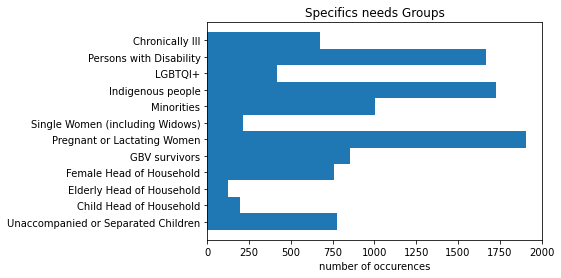

In [67]:
plt.barh(list(lengthes_dict.keys()), list(lengthes_dict.values()), 1)
plt.xlabel('number of occurences')
plt.title('Specifics needs Groups')

In [68]:
Demographic_groups_raw_to_processed_dict = {
    'Adult (18 to 59 years old)':['Adult Female (18 to 59 years old)', 'Adult Male (18 to 59 years old)'],
    'Adult (18-59 years old)':['Adult Female (18 to 59 years old)', 'Adult Male (18 to 59 years old)'],
    'Adult Female (18 to 59 years old)':['Adult Female (18 to 59 years old)'],
    'Adult female (18 to 59 years old)':['Adult Female (18 to 59 years old)'],
    'Adult female (18-59 years old)':['Adult Female (18 to 59 years old)'],
    'Adult Male (18 to 59 years old)':['Adult Male (18 to 59 years old)'],
    'Adult (25 to 59 years old)':['Adult Female (18 to 59 years old)', 'Adult Male (18 to 59 years old)'],
    'Youth (18 to 24 years old)':['Adult Female (18 to 59 years old)', 'Adult Male (18 to 59 years old)'],
    'Adult Female (25 to 59 years old)':['Adult Female (18 to 59 years old)'],
    'Adult Male (25 to 59 years old)':['Adult Male (18 to 59 years old)'],
    'Youth Female (18 to 24 years old)':['Adult Female (18 to 59 years old)'],
    'Youth Male (18 to 24 years old)':['Adult Male (18 to 59 years old)'],
    'Adult male (18-59 years old)':['Adult Male (18 to 59 years old)'],
    
    'Female Older Persons (60+ years old)':['Older Persons Female (60+ years old)'],
    'Male Older Persons (60+ years old)':['Older Persons Male (60+ years old)'],
    'Older Persons (60+ years old)':['Older Persons Female (60+ years old)', 'Older Persons Male (60+ years old)'],
    'Older Persons Female (60+ years old)':['Older Persons Female (60+ years old)'],
    'Older Persons Male (60+ years old)':['Older Persons Male (60+ years old)'],
    'Older persons (60+ years old)':['Older Persons Female (60+ years old)', 'Older Persons Male (60+ years old)'],
    'Older persons female (60+ years old)':['Older Persons Female (60+ years old)'],
    'Older persons male (60+ years old)':['Older Persons Male (60+ years old)'],
    
    'Infants/Toddlers (<5 years old)':['Infants/Toddlers (<5 years old)'],
    'Infants/toddlers (<5)':['Infants/Toddlers (<5 years old)'],
    'Infants (0-2 years old)':['Infants/Toddlers (<5 years old)'],
    'Children (0-4 years old)':['Infants/Toddlers (<5 years old)'],
    
    #'Children Male (5 to 1 years old) 
    'Children (5 to 11 years old)':['Children/Youth Male (5 to 17 years old)', 'Children/Youth Female (5 to 17 years old)'],
    'Children (5 to 17 years old)':['Children/Youth Male (5 to 17 years old)', 'Children/Youth Female (5 to 17 years old)'],
    'Children (5-11 years old)':['Children/Youth Male (5 to 17 years old)', 'Children/Youth Female (5 to 17 years old)'],
    'Children (< 18 years)':['Children/Youth Male (5 to 17 years old)', 'Children/Youth Female (5 to 17 years old)'],
    'Children Female  <18 years old':['Children/Youth Female (5 to 17 years old)'],
    'Children Female (5 to 11 years old)':['Children/Youth Female (5 to 17 years old)'],
    'Children Female (5 to 17 years old)':['Children/Youth Female (5 to 17 years old)'],
    'Children Female (< 18 years)':['Children/Youth Female (5 to 17 years old)'],
    'Children Male (5 to 11 years old)':['Children/Youth Male (5 to 17 years old)'],
    'Children Male (< 18 years)':['Children/Youth Male (5 to 17 years old)'],
    'Children Male < 18 years old':['Children/Youth Male (5 to 17 years old)'],
    'Children female (5-11 years old)':['Children/Youth Female (5 to 17 years old)'],
    'Children male (5-11 years old)':['Children/Youth Male (5 to 17 years old)'],
    'Youth (12 to 17 years old)':['Children/Youth Male (5 to 17 years old)', 'Children/Youth Female (5 to 17 years old)'],
    'Youth (12-17 years old)':['Children/Youth Male (5 to 17 years old)', 'Children/Youth Female (5 to 17 years old)'],
    'Youth Female (12 to 17 years old)':['Children/Youth Female (5 to 17 years old)'],
    'Youth Male (12 to 17 years old)':['Children/Youth Male (5 to 17 years old)'],
    'Youth female (12-17 years old)':['Children/Youth Female (5 to 17 years old)'],
    'Youth male (12-17 years old)':['Children/Youth Male (5 to 17 years old)'],
    'Children Male (5 to 1 years old)':['Children/Youth Male (5 to 17 years old)']
}

In [69]:
import numpy as np
np.unique(list(Demographic_groups_raw_to_processed_dict.values()))

/home/selim/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


array([list(['Adult Female (18 to 59 years old)']),
       list(['Adult Female (18 to 59 years old)', 'Adult Male (18 to 59 years old)']),
       list(['Adult Male (18 to 59 years old)']),
       list(['Children/Youth Female (5 to 17 years old)']),
       list(['Children/Youth Male (5 to 17 years old)']),
       list(['Children/Youth Male (5 to 17 years old)', 'Children/Youth Female (5 to 17 years old)']),
       list(['Infants/Toddlers (<5 years old)']),
       list(['Older Persons Female (60+ years old)']),
       list(['Older Persons Female (60+ years old)', 'Older Persons Male (60+ years old)']),
       list(['Older Persons Male (60+ years old)'])], dtype=object)

In [70]:
type([1,2])

list

In [71]:
def flatten_list(t):
    
    return [item for sublist in t for item in sublist]

demographic_groups_tags_df = entries_labeled_secondary_tags_cleaned[entries_labeled_secondary_tags_cleaned.tag_title=='Demographic Groups']\
                            .drop(columns=['tag_title'])
demographic_groups_tags_df['tag_value'] =\
            demographic_groups_tags_df['tag_value'].apply(
    lambda list_tags: flatten_list([
        Demographic_groups_raw_to_processed_dict[tag]\
        for tag in list_tags if (tag!='Children Male (5 to 1 years old)' and tag!='Female' and tag!='Male')
    ])
)



In [72]:
demographic_groups_tags_df = demographic_groups_tags_df[
    demographic_groups_tags_df.tag_value.apply(lambda x: x!=[])
]
demographic_groups_tags_df

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_value
192,Shelter and non-food items are mentioned as pr...,699,25509,1142,IFRC Turkey,90516,5297,"[Children/Youth Male (5 to 17 years old), Chil..."
306,"Au plan national, 21,9% des enfants de 6-23 mo...",1306,49808,2099,IMMAP/DFS Burkina Faso,271697,8624,[Infants/Toddlers (<5 years old)]
347,Una de las preocupaciones para las elecciones ...,829,19935,1183,UNHCR Colombia,69488,5916,"[Adult Female (18 to 59 years old), Adult Male..."
489,Women and girls who have fled Venezuela are at...,829,12703,1184,UNHCR Ecuador,51349,5916,"[Children/Youth Male (5 to 17 years old), Chil..."
857,"MAPUTO, MOZAMBIQUE – Monday 18 March 2019 – Fe...",273,10485,878,"IFRC - Cyclone Idai, March 2019",27578,3142,"[Children/Youth Male (5 to 17 years old), Chil..."
...,...,...,...,...,...,...,...,...
739921,3.10 Experience in seeking health services for...,1306,63488,2098,IMMAP/DFS Bangladesh,412929,8624,"[Children/Youth Male (5 to 17 years old), Chil..."
739956,The persons/children with disabilities who sou...,1306,63488,2098,IMMAP/DFS Bangladesh,412942,8624,"[Children/Youth Male (5 to 17 years old), Chil..."
739989,Alors que le phénomène des violences sexuelles...,1306,63086,2225,IMMAP/DFS RDC,412826,8624,[Adult Male (18 to 59 years old)]
740033,"Dans la localité de Djaiba, les enseignants on...",1306,63087,2225,IMMAP/DFS RDC,412991,8624,"[Children/Youth Male (5 to 17 years old), Chil..."


In [73]:
#demographic_groups_tags_df.to_csv('data_secondary_tags/demographics_groups_tags_initial.csv')

In [74]:
values_demographic = flatten_list(list(Demographic_groups_raw_to_processed_dict.values()))


In [75]:
lengthes_dict = {}
for value in values_demographic:

    len_tmp = demographic_groups_tags_df[demographic_groups_tags_df.tag_value\
                               .apply(lambda x: value in x)].shape[0]
    lengthes_dict[value]=len_tmp

In [76]:
lengthes_dict

{'Adult Female (18 to 59 years old)': 7711,
 'Adult Male (18 to 59 years old)': 3639,
 'Older Persons Female (60+ years old)': 4792,
 'Older Persons Male (60+ years old)': 2928,
 'Infants/Toddlers (<5 years old)': 3224,
 'Children/Youth Male (5 to 17 years old)': 13607,
 'Children/Youth Female (5 to 17 years old)': 16304}

Text(0.5, 1.0, 'Demographic Groups')

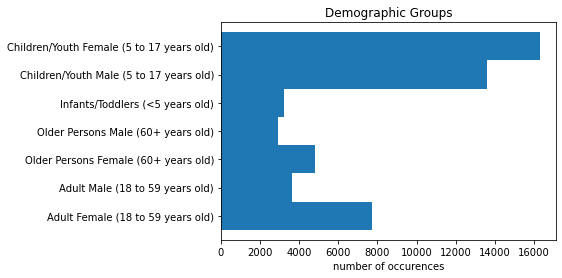

In [77]:
plt.barh(list(lengthes_dict.keys()), list(lengthes_dict.values()), 1)
plt.xlabel('number of occurences')
plt.title('Demographic Groups')

In [78]:
list(lengthes_dict.keys())

['Adult Female (18 to 59 years old)',
 'Adult Male (18 to 59 years old)',
 'Older Persons Female (60+ years old)',
 'Older Persons Male (60+ years old)',
 'Infants/Toddlers (<5 years old)',
 'Children/Youth Male (5 to 17 years old)',
 'Children/Youth Female (5 to 17 years old)']

In [79]:
def clean_names(x):
    return x.replace('Others of Concern','Others').replace('affected','Affected')

def preprocess_lists_affected_groups(t):
    return list(np.unique([
        clean_names(item) for sublist in t for item in sublist if item not in [
            '', 'Out of Venezuela', 'Back to Venezuela', 'All',
            'Stateless', 'Non Host', 'Not Affected', 'Not affected', 'Pendular',
            
    ]]))

In [80]:
affected_groups = exportdata[exportdata.tag_title=='Affected Groups']
affected_groups = affected_groups[affected_groups.tag_value.apply(lambda x: x!=[])]
affected_groups['tag_value'] = affected_groups.tag_value.progress_apply(preprocess_lists_affected_groups)

  0%|          | 0/113938 [00:00<?, ?it/s]

In [81]:
affected_groups.head(2)

,id,data,entry_id,exportable_id,tag_title,tag_value
2,1633663,"{""excel"": {""type"": ""lists"", ""values"": [["""", ""A...",338269,8622,Affected Groups,"[Affected, Displaced, Host, Non Displaced, Ref..."
7,998839,"{""excel"": {""type"": ""lists"", ""values"": [["""", ""A...",202094,9460,Affected Groups,"[Affected, Displaced, Returnees]"


In [82]:
list_all_tags = affected_groups.tag_value.tolist()
flattened = flatten_list(list_all_tags)
Counter(flattened)

Counter({'Affected': 106945,
         'Displaced': 69626,
         'Host': 8513,
         'Non Displaced': 10481,
         'Refugees': 22135,
         'Returnees': 7478,
         'Others': 10815,
         'Migrants': 22840,
         'IDP': 19733,
         'Permanent': 4875,
         'Asylum Seekers': 3212,
         'In transit': 2284})

In [83]:
values_demographic = list(Demographic_groups_raw_to_processed_dict.values())

In [84]:
print(f" demographic groups: {demographic_groups_tags_df.shape[0]}\n",
f"specific needs groups: {specific_needs_groups_tags_df.shape[0]}\n",
f"severity: {severity_tags_df.shape[0]}\n",
f"reliability: {reliabillity_tags_df.shape[0]}\n",
f"date: {date_tags_df.shape[0]}\n",
f"geo location: {geo_loc_df.shape[0]}\n",
f"affected groups: {affected_groups.shape[0]}")

 demographic groups: 22830
 specific needs groups: 8082
 severity: 44674
 reliability: 155304
 date: 63188
 geo location: 138809
 affected groups: 113938


In [85]:
reliabillity_tags_df

,excerpt,analysis_framework_id,lead_id,project_id,title,entry_id,exportable_id,tag_value
1,"On March 19, search-andrescue personnel airlif...",273,10607,878,"IFRC - Cyclone Idai, March 2019",25639,3145,[Usually reliable]
9,"Currently, there are 139,771 confirmed cases i...",699,28940,1142,IFRC Turkey,102051,5295,[Usually reliable]
20,"According to The Guardian, more than 9,000 ref...",552,8644,788,Nigeria Situation Analysis (OA),21660,4690,[Usually reliable]
37,SANCAKTEPE SUB-PROVINCE: According to Baseline...,699,25511,1142,IFRC Turkey,96070,5295,[Usually reliable]
73,Spanish RC – providing support in transportati...,273,10437,878,"IFRC - Cyclone Idai, March 2019",25635,3145,[Usually reliable]
...,...,...,...,...,...,...,...,...
740030,Une structure sanitiare est fonctionnelle à Dj...,1306,63087,2225,IMMAP/DFS RDC,412992,8623,[Usually reliable]
740035,"Dans la localité de Djaiba, les enseignants on...",1306,63087,2225,IMMAP/DFS RDC,412991,8623,[Usually reliable]
740039,L'activité économique a fortement ralenti en 2...,1306,63089,2225,IMMAP/DFS RDC,413010,8623,[Usually reliable]
740043,"L'inflation a grimpé en flèche, alimentée par ...",1306,63089,2225,IMMAP/DFS RDC,413011,8623,[Usually reliable]


In [86]:
entries_cleaned_final = entries.drop(columns=[
    'tabular_field_id',
   'image_id',
   'image_raw', 
   'created_at', 
   'modified_at', 
   'created_by_id', 
   'modified_by_id',
   'dropped_excerpt', 
   'highlight_hidden', 
   'verified', 
   'verification_last_changed_by_id', 
   'client_id',
  'information_date',
  'order'
]).rename(columns={'id':'entry_id'}).dropna()

In [87]:
final_secondary_tags =\
    pd.merge(entries_cleaned_final,
             geo_loc_df[['entry_id', 'tag_value']]\
                .rename(columns={'tag_value':'geo_location'}),
             how="left",
             on="entry_id")

final_secondary_tags =\
    pd.merge(final_secondary_tags,
             specific_needs_groups_tags_df[['entry_id', 'tag_value']]\
                .rename(columns={'tag_value':'specific_needs_groups'}),
             how="left",
             on="entry_id")

final_secondary_tags =\
    pd.merge(final_secondary_tags,
             severity_tags_df[['entry_id', 'tag_value']]\
                .rename(columns={'tag_value':'severity'}),
             how="left",
             on="entry_id")

final_secondary_tags =\
    pd.merge(final_secondary_tags,
             date_tags_df[['entry_id', 'tag_value']]\
                .rename(columns={'tag_value':'dates'}),
             how="left",
             on="entry_id")

final_secondary_tags =\
    pd.merge(final_secondary_tags,
             demographic_groups_tags_df[['entry_id', 'tag_value']]\
                .rename(columns={'tag_value':'demographic_groups'}),
             how="left",
             on="entry_id")

final_secondary_tags =\
    pd.merge(final_secondary_tags,
             reliabillity_tags_df[['entry_id', 'tag_value']]\
                .rename(columns={'tag_value':'reliability'}),
             how="left",
             on="entry_id")

final_secondary_tags =\
    pd.merge(final_secondary_tags,
             affected_groups[['entry_id', 'tag_value']]\
                .rename(columns={'tag_value':'affected_groups'}),
             how="left",
             on="entry_id")

In [88]:
final_secondary_tags = final_secondary_tags[~(
    final_secondary_tags.analysis_framework_id.isna() | 
    final_secondary_tags.entry_id.isna() |
    final_secondary_tags.lead_id.isna() |
    final_secondary_tags.excerpt.isna())
]

In [89]:
sec_tags = ['geo_location', 
     'specific_needs_groups', 
     'severity', 
     'demographic_groups', 
     'reliability', 
     'affected_groups']

for tag in sec_tags:
    final_secondary_tags[tag] = final_secondary_tags[tag].fillna("").apply(list)

In [90]:
final_secondary_tags['dates'] = final_secondary_tags['dates'].fillna("UNKNOWN")

In [91]:
final_secondary_tags.iloc[131075]

entry_id                                                            317380
excerpt                  Cameroon has ratified the International Covena...
analysis_framework_id                                                 1465
lead_id                                                              48435
entry_type                                                         excerpt
project_id                                                            2334
title                                                       GIMAC Cameroon
geo_location                                                    [Cameroon]
specific_needs_groups                                                   []
severity                                                                []
dates                                                              UNKNOWN
demographic_groups       [Children/Youth Male (5 to 17 years old), Chil...
reliability                                             [Usually reliable]
affected_groups          

In [92]:
final_secondary_tags.shape

(155891, 14)

In [93]:
final_secondary_tags.tail()

,entry_id,excerpt,analysis_framework_id,lead_id,entry_type,project_id,title,geo_location,specific_needs_groups,severity,dates,demographic_groups,reliability,affected_groups
155886,412992,Une structure sanitiare est fonctionnelle à Dj...,1306,63087,excerpt,2225,IMMAP/DFS RDC,[Djugu],[],[Major],"[12-06-2021, 28-06-2021]",[],[Usually reliable],"[Affected, Displaced, IDP]"
155887,412991,"Dans la localité de Djaiba, les enseignants on...",1306,63087,excerpt,2225,IMMAP/DFS RDC,[Djugu],[],[Major],"[12-06-2021, 28-06-2021]","[Children/Youth Male (5 to 17 years old), Chil...",[Usually reliable],"[Affected, Displaced, IDP]"
155888,413010,L'activité économique a fortement ralenti en 2...,1306,63089,excerpt,2225,IMMAP/DFS RDC,[République démocratique du Congo],[],[],UNKNOWN,[],[Usually reliable],[]
155889,413011,"L'inflation a grimpé en flèche, alimentée par ...",1306,63089,excerpt,2225,IMMAP/DFS RDC,[République démocratique du Congo],[],[],UNKNOWN,[],[Usually reliable],[]
155890,402428,"Nariño | En Ipiales, el 26 de mayo se realizó ...",829,63199,excerpt,1183,UNHCR Colombia,[Ipiales],[],[],"[27-05-2021, 02-06-2021]","[Children/Youth Male (5 to 17 years old), Chil...",[Usually reliable],"[Affected, Displaced, In transit, Migrants]"


In [94]:
#final_secondary_tags.to_csv('generated_entries/secondary_tags.csv', index=None)

## Merging with primary tags

In [95]:
primary_tags = pd.read_csv('generated_entries/primary_tags.csv')
primary_tags_gimmac = pd.read_csv('generated_entries/primary_tags_gimmac_data.csv')


In [96]:
all_dataset = pd.concat([primary_tags, primary_tags_gimmac])
all_dataset = all_dataset.drop_duplicates()

In [97]:
all_dataset = all_dataset[~(
    all_dataset.analysis_framework_id.isna() | 
    all_dataset.entry_id.isna() |
    all_dataset.lead_id.isna() |
    all_dataset.excerpt.isna())
]
all_dataset.shape

(160387, 13)

In [98]:
final_merged = pd.merge(
    left=all_dataset,
    right=final_secondary_tags,
    how='outer',
    on='entry_id'
)
final_merged.columns 

Index(['entry_id', 'excerpt_x', 'entry_type_x', 'analysis_framework_id_x',
       'lead_id_x', 'title_x', 'project_id_x', 'verified', 'sectors',
       'subpillars_2d', 'subpillars_1d', 'pillars_1d', 'pillars_2d',
       'excerpt_y', 'analysis_framework_id_y', 'lead_id_y', 'entry_type_y',
       'project_id_y', 'title_y', 'geo_location', 'specific_needs_groups',
       'severity', 'dates', 'demographic_groups', 'reliability',
       'affected_groups'],
      dtype='object')

In [99]:
final_merged['excerpt'] = final_merged.apply(lambda x: x.excerpt_y if pd.isna(x.excerpt_x) else x.excerpt_x, axis=1)
final_merged = final_merged[~final_merged.excerpt.isna()].drop(columns=['excerpt_x', 'excerpt_y'])

final_merged['analysis_framework_id'] = final_merged.apply(
    lambda x: x.analysis_framework_id_y if pd.isna(x.analysis_framework_id_x) else x.analysis_framework_id_x, axis=1
)
final_merged = final_merged[
    ~final_merged.analysis_framework_id.isna()
].drop(columns=['analysis_framework_id_x', 'analysis_framework_id_y'])

final_merged['lead_id'] = final_merged.apply(lambda x: x.lead_id_y if pd.isna(x.lead_id_x) else x.lead_id_x, axis=1)
final_merged = final_merged[~final_merged.lead_id.isna()].drop(columns=['lead_id_x', 'lead_id_y'])

final_merged['project_id'] = final_merged.apply(lambda x: x.project_id_y if pd.isna(x.project_id_x) else x.project_id_x, axis=1)
final_merged = final_merged[~final_merged.project_id.isna()].drop(columns=['project_id_x', 'project_id_y'])

final_merged['title'] = final_merged.apply(lambda x: x.title_y if pd.isna(x.title_x) else x.title_x, axis=1)
final_merged = final_merged[~final_merged.title.isna()].drop(columns=['title_x', 'title_y'])

final_merged['entry_type'] = final_merged.apply(lambda x: x.entry_type_y if pd.isna(x.entry_type_x) else x.entry_type_x, axis=1)
final_merged = final_merged[~final_merged.title.isna()].drop(columns=['entry_type_x', 'entry_type_y'])

In [100]:
tags = ['geo_location', 
     'specific_needs_groups', 
     'severity', 
     'demographic_groups', 
     'reliability', 
     'affected_groups',
        'sectors', 
     'subpillars_2d',
     'subpillars_1d']

for tag in tags:
    final_merged[tag] = final_merged[tag].fillna("").apply(lambda x: [] if x=="" else x)

In [101]:
final_merged = final_merged[
    ['entry_id', 'excerpt', 'analysis_framework_id', 'lead_id',
       'project_id', 'title', 'entry_type', 'verified', 'sectors', 'subpillars_2d', 'subpillars_1d',
     'geo_location', 'specific_needs_groups',
       'severity', 'dates', 'demographic_groups', 'reliability',
       'affected_groups']
]

## leads

In [102]:
leads = pd.read_csv('leads.csv').rename(columns={'id':'lead_id'})[
    ['lead_id', 'source_type', 'url', 'website']
]
leads.columns

Index(['lead_id', 'source_type', 'url', 'website'], dtype='object')

In [103]:
final_merged = pd.merge(
    left=final_merged,
    right=leads,
    how='left',
    on='lead_id'
)

In [104]:
final_merged.to_csv('generated_entries/full_dataset.csv', index=None)

## testing it works well:

In [105]:
test = pd.read_csv('generated_entries/full_dataset.csv')

/home/selim/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [106]:
test.shape, test.columns

((163875, 21),
 Index(['entry_id', 'excerpt', 'analysis_framework_id', 'lead_id', 'project_id',
        'title', 'entry_type', 'verified', 'sectors', 'subpillars_2d',
        'subpillars_1d', 'geo_location', 'specific_needs_groups', 'severity',
        'dates', 'demographic_groups', 'reliability', 'affected_groups',
        'source_type', 'url', 'website'],
       dtype='object'))

In [ ]:
test